<a href="https://colab.research.google.com/drive/1cuJsP-X7pOdvQGRxOBESp9N9HSiSUemQ?usp=sharing">
  <img align="center" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!pip install transformers
!pip install sentencepiece
#!pip install tensorflow==2.4.0 

     |████████████████████████████████| 2.6 MB 8.0 MB/s 
     |████████████████████████████████| 895 kB 67.7 MB/s 
     |████████████████████████████████| 3.3 MB 61.8 MB/s 
     |████████████████████████████████| 636 kB 60.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 8.5 MB/s 


In [ ]:
# import module
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import nltk
nltk.download("stopwords")
AUTO = tf.data.experimental.AUTOTUNE
MAX_LENGTHS = 50

NUM_CATEGORICAL = 3
dfResult = pd.DataFrame(columns=[ "rataAccTrain", "rataAccVal",
                    "rataLossTrain", "rataLossVal",
                    "precisionTrain","precisionVal",
                    "recallTrain","recallVal","ModelName"])
HISTORY_TRANSFORMERS = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


IMPORTING ALL DATASETS

In [ ]:
!gdown --id 1dhdMKM9akp0krL9ObL-kn8K9gSVOwPUp
!gdown --id 1160UzrabHFjB4QjLs6IWU4mZ6fZroGNf
!gdown --id 10FbqBhDzGl_JsFLxFI8SvWmouc0FWQtd

Downloading...
From: https://drive.google.com/uc?id=1dhdMKM9akp0krL9ObL-kn8K9gSVOwPUp
To: /content/AllData.csv
3.25MB [00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1160UzrabHFjB4QjLs6IWU4mZ6fZroGNf
To: /content/All Data Undersampling Max 200.csv
100% 895k/895k [00:00<00:00, 59.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=10FbqBhDzGl_JsFLxFI8SvWmouc0FWQtd
To: /content/Normal.csv
100% 443k/443k [00:00<00:00, 60.5MB/s]


## Yow Read the Dataset

In [ ]:
!pip install openpyxl

In [ ]:
dfAllData = pd.read_csv("All Data Undersampling Max 200.csv")

In [ ]:
sample = dfAllData.loc[1,"tweet"]
def cleanIt(text):
  
  text = str(text)
  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[#]+|[^A-Za-z0-9]+"
  text_cleaning_hash = "#[A-Za-z0-9]+" 

  text = re.sub(text_cleaning_hash, " ",text).rstrip()
  text = re.sub(text_cleaning_re, " ",text).rstrip()
  
  return text
cleanIt(sample)

'status dukung gerakan matikan lilin untuk ahok gubernur sebut akun facebok dihack'

In [ ]:
stopword = nltk.corpus.stopwords.words('indonesian')
def stopWord(text):
  text = text.split()
  return " ".join([t for t in text if t not in stopword])
stopWord("bilamana apabila saya  ")

'bilamana'

In [ ]:
dfNormal = pd.read_csv("Normal.csv")
dfAllData = dfAllData[dfAllData["labels"] != 0]


In [ ]:
dfAllData.loc[dfAllData["labels"] == 3,"labels"]= 2

In [ ]:
dfNormal.loc[:,"labels"] = 0

In [ ]:
dfAllData = pd.concat([dfAllData,dfNormal])

In [ ]:
dfAllData["tweet"] = dfAllData["tweet"].apply(cleanIt)
dfAllData["tweet"] = dfAllData["tweet"].apply(stopWord)
dfAllData = dfAllData[dfAllData["tweet"].apply(lambda x : len(x.rstrip().split()) > 4) == True ]
dfAllData[dfAllData["tweet"].apply(lambda x : len(x.split()) < 4) == True]

,tweet,labels


In [ ]:
for i in range(5):
    dfAllData = dfAllData.sample(frac=1).reset_index(drop=True)

In [ ]:
dfAllData

,tweet,labels
0,videos of italian suicide who lost entire fami...,1
1,tahapan pelaksanan skb cpns penentuan peserta ...,1
2,anies sandi dikenang sejarah menang terhormat ...,2
3,resto dijadikan salah pilihan makan dipusat ko...,0
4,isu bohong kali kepala divisi hubungan masyara...,1
...,...,...
6380,benaran ikan duyung benaran sesuai gambaran ca...,1
6381,bank mandiri kartu kredit senilai rp orang cep...,1
6382,pb dunia kumpulkan dana kemanusian rp triliun ...,2
6383,disinformasi diedarkan sabu kristal pipapipa b...,1


In [ ]:
import plotly.graph_objects as go
counted = dfAllData.groupby('labels')["labels"].aggregate("count")
print(counted)
fig = go.Figure()
fig.add_traces(go.Bar(y = ["Normal","Berita Bohong","HateSpeech","Offensive"],x = counted,orientation="h"))
fig.show()

labels
0    1759
1    1657
2    2969
Name: labels, dtype: int64


## TransferLearning Section menggunakan transformer model

In [ ]:
# Check panjang text Narasi
from collections import Counter
seq_len = [len(text.split()) for text in dfAllData["tweet"] if type(text) != float]
print(Counter(seq_len))

Counter({6: 471, 7: 464, 5: 438, 9: 416, 8: 407, 12: 369, 10: 368, 11: 366, 13: 263, 14: 257, 15: 235, 18: 194, 16: 174, 17: 164, 19: 153, 20: 128, 23: 115, 21: 114, 22: 111, 24: 107, 27: 84, 26: 83, 25: 82, 29: 76, 28: 76, 31: 64, 30: 60, 32: 54, 35: 43, 34: 42, 33: 41, 36: 36, 37: 31, 39: 27, 41: 25, 40: 23, 38: 22, 42: 22, 43: 18, 44: 10, 45: 9, 46: 8, 48: 8, 47: 6, 57: 5, 84: 5, 54: 4, 59: 4, 74: 3, 75: 3, 52: 3, 55: 3, 110: 3, 98: 3, 108: 3, 61: 3, 58: 3, 93: 2, 96: 2, 120: 2, 88: 2, 79: 2, 69: 2, 114: 2, 76: 2, 62: 2, 53: 2, 116: 2, 115: 2, 49: 2, 68: 2, 121: 2, 67: 2, 135: 2, 89: 2, 82: 2, 131: 2, 70: 2, 77: 1, 97: 1, 51: 1, 64: 1, 56: 1, 173: 1, 107: 1, 102: 1, 118: 1, 87: 1, 123: 1, 104: 1, 66: 1, 112: 1, 81: 1, 127: 1, 128: 1, 60: 1, 92: 1, 124: 1, 148: 1, 85: 1, 113: 1, 122: 1, 111: 1, 73: 1, 141: 1, 171: 1, 164: 1, 50: 1, 169: 1, 159: 1, 119: 1, 133: 1})


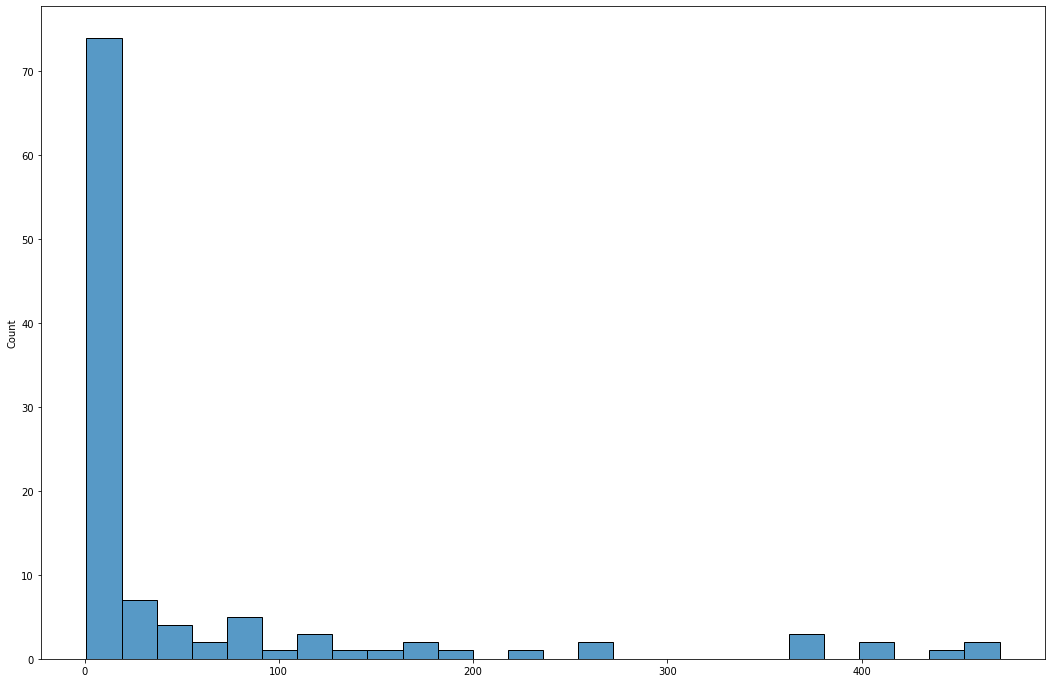

In [ ]:
plt.figure(figsize=(18,12))
sns.histplot(list(dict(Counter(seq_len)).values()))

In [ ]:
METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
  ]

In [ ]:
WORD_SIZE = 5000
def dataForLstm():
  from tensorflow.keras.preprocessing.text import Tokenizer
  tokenizer = Tokenizer(num_words = WORD_SIZE)
  tokenizer.fit_on_texts(dfAllData["tweet"].values)
  X = tokenizer.texts_to_sequences(dfAllData["tweet"].values)
  X = tf.keras.preprocessing.sequence.pad_sequences(X,maxlen=MAX_LENGTHS)
  Ylstm = tf.keras.utils.to_categorical(dfAllData["labels"])
  #x_trainlstm,x_valLstm,y_trainlstm,y_valLstm = train_test_split(X,Ylstm,test_size=0.2,random_state=1)
  #return x_trainlstm,x_valLstm,y_trainlstm,y_valLstm
  return X,Ylstm
"""from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = WORD_SIZE)
tokenizer.fit_on_texts(dfAllData["tweet"].values)
X = tokenizer.texts_to_sequences(dfAllData["tweet"].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X)
Ylstm = tf.keras.utils.to_categorical(dfAllData["labels"])
#x_trainlstm,x_valLstm,y_trainlstm,y_valLstm = train_test_split(X,Ylstm,test_size=0.001,random_state=1)
tokenizer.sequences_to_texts([x_trainlstm[0]])
#return x_trainlstm,x_valLstm,y_trainlstm,y_valLstm"""

'from tensorflow.keras.preprocessing.text import Tokenizer\ntokenizer = Tokenizer(num_words = WORD_SIZE)\ntokenizer.fit_on_texts(dfAllData["tweet"].values)\nX = tokenizer.texts_to_sequences(dfAllData["tweet"].values)\nX = tf.keras.preprocessing.sequence.pad_sequences(X)\nYlstm = tf.keras.utils.to_categorical(dfAllData["labels"])\n#x_trainlstm,x_valLstm,y_trainlstm,y_valLstm = train_test_split(X,Ylstm,test_size=0.001,random_state=1)\ntokenizer.sequences_to_texts([x_trainlstm[0]])\n#return x_trainlstm,x_valLstm,y_trainlstm,y_valLstm'

In [ ]:
#Not Using its Attention to train.


def dataforIndoBert():
  tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

  token_train = {
      "tweet" : tokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }
  data = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_train["tweet"]["input_ids"])),
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return data["tweet"].numpy(),Y


def dataforRoberta():
  RobertaModelName = "cahya/roberta-base-indonesian-522M"
  RobertaTokenizer = AutoTokenizer.from_pretrained(RobertaModelName)
  token_train_Roberta = {
      "tweet" : RobertaTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }

  train_dataRoberta = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_Roberta["tweet"]["input_ids"]))
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_dataRoberta["tweet"].numpy(),Y


def dataforBert():
  BertModelName = "cahya/bert-base-indonesian-522M"
  BertModelTokenizer = AutoTokenizer.from_pretrained(RobertaModelName)
  token_train_bert = {
      "tweet" : BertModelTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }
  train_databert = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_bert["tweet"]["input_ids"]))
  }


  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_databert["tweet"].numpy(),Y

def dataforGPT2():
  GPT2Modelname = "cahya/gpt2-small-indonesian-522M"
  Gpt2ModelTokenizer = AutoTokenizer.from_pretrained(GPT2Modelname)
  Gpt2ModelTokenizer.pad_token = Gpt2ModelTokenizer.eos_token
  token_train_GPT2 = {
      "tweet" : Gpt2ModelTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          
          truncation = True
      ),
  }

  train_dataGPT2 = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_GPT2["tweet"]["input_ids"]))
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_dataGPT2["tweet"].numpy(),Y
def dataforXLMRoBERTa():

  XLMRobertaName = "jplu/tf-xlm-roberta-base"
  XLMRobertaMultiLingualTokenizer = AutoTokenizer.from_pretrained(XLMRobertaName)

  token_train_XLMRoberta = {
      "tweet" : XLMRobertaMultiLingualTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }

  train_dataXLMRoberta = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_XLMRoberta["tweet"]["input_ids"]))
  }

  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_dataXLMRoberta["tweet"].numpy(), Y

In [ ]:
#Not Using its Attention to train.

def dataforIndoBertAttention():
  tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

  token_train = {
      "tweet" : tokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }
  data = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_train["tweet"]["input_ids"])),
    "tweetMask" :  tf.squeeze(tf.convert_to_tensor(token_train["tweet"]["attention_mask"]))
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)
  data = {
      "tweet" : data["tweet"].numpy(),
      "tweetMask" : data["tweet"].numpy()
  }
  return data,Y


def dataforRobertaAttention():
  RobertaModelName = "cahya/roberta-base-indonesian-522M"
  RobertaTokenizer = AutoTokenizer.from_pretrained(RobertaModelName)
  token_train_Roberta = {
      "tweet" : RobertaTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }

  train_dataRoberta = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_Roberta["tweet"]["input_ids"])),
       "tweetMask" :  tf.squeeze(tf.convert_to_tensor(token_train_Roberta["tweet"]["attention_mask"]))
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)
  train_dataRoberta = {
      "tweet" : train_dataRoberta["tweet"].numpy(),
      "tweetMask" : train_dataRoberta["tweet"].numpy()
  }
  return train_dataRoberta,Y


def dataforBertAttentions():
  BertModelName = "cahya/bert-base-indonesian-522M"
  BertModelTokenizer = AutoTokenizer.from_pretrained(RobertaModelName)
  token_train_bert = {
      "tweet" : BertModelTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }
  train_databert = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_bert["tweet"]["input_ids"])),
      "tweetMask" :  tf.squeeze(tf.convert_to_tensor(token_train_bert["tweet"]["attention_mask"]))
  }


  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)
  train_databert = {
      "tweet" : train_databert["tweet"].numpy(),
      "tweetMask" : train_databert["tweet"].numpy()
  }
  return train_databert,Y

def dataforGPT2Attentions():
  GPT2Modelname = "cahya/gpt2-small-indonesian-522M"
  Gpt2ModelTokenizer = AutoTokenizer.from_pretrained(GPT2Modelname)
  Gpt2ModelTokenizer.pad_token = Gpt2ModelTokenizer.eos_token
  token_train_GPT2 = {
      "tweet" : Gpt2ModelTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          
          truncation = True
      ),
  }

  train_dataGPT2 = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_GPT2["tweet"]["input_ids"])),
      "tweetMask" :  tf.squeeze(tf.convert_to_tensor(token_train_GPT2["tweet"]["attention_mask"]))
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)
  train_dataGPT2 = {
      "tweet" : train_dataGPT2["tweet"].numpy(),
      "tweetMask" : train_dataGPT2["tweet"].numpy()
  }
  return train_dataGPT2,Y
def dataforXLMRoBERTaAttention():

  XLMRobertaName = "jplu/tf-xlm-roberta-base"
  XLMRobertaMultiLingualTokenizer = AutoTokenizer.from_pretrained(XLMRobertaName)

  token_train_XLMRoberta = {
      "tweet" : XLMRobertaMultiLingualTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }

  train_dataXLMRoberta = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_XLMRoberta["tweet"]["input_ids"])),
      "tweetMask" :  tf.squeeze(tf.convert_to_tensor(token_train_XLMRoberta["tweet"]["attention_mask"]))
  }

  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)
  train_dataXLMRoberta = {
      "tweet" : train_dataXLMRoberta["tweet"].numpy(),
      "tweetMask" : train_dataXLMRoberta["tweet"].numpy()
  }
  return train_dataXLMRoberta, Y

In [ ]:
## Architecture
def architectureTransformers(passedModel):
  METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
  ]

  ids1 = tf.keras.layers.Input(shape=(MAX_LENGTHS,),dtype=tf.int32,name="tweet")
  #attentions = tf.keras.layers.Input(shape=(MAX_LENGTHS,),dtype=tf.int32,name="tweetMask")
  last_hidden_state, pooler_output = passedModel(ids1).to_tuple()
  layers = tf.keras.layers.Flatten()(last_hidden_state)
  layers = tf.keras.layers.Dropout(0.3)(layers)
  layers = tf.keras.layers.Dense(1024,activation=tf.nn.relu)(layers)
  layers = tf.keras.layers.Dense(128,activation=tf.nn.relu)(layers)
  layers = tf.keras.layers.Dropout(0.3)(layers)
  fin_layer = tf.keras.layers.Dense(NUM_CATEGORICAL,activation= tf.nn.softmax)(layers)

  final = tf.keras.Model(inputs=[ids1],outputs=[fin_layer])
  
  for layer in final.layers:
      layer.trainable = False
  for layer in final.layers[2:]:
    layer.trainable = True 
  optimizer = tf.keras.optimizers.Adam(learning_rate=.0001)
  final.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer,metrics = METRICS)

  return final

In [ ]:
METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),]

In [ ]:
def indoBertModelAttention():
  ids1 = tf.keras.layers.Input(shape=(MAX_LENGTHS,),dtype=tf.int32,name="tweet")
  attention = tf.keras.layers.Input(shape=(MAX_LENGTHS,),dtype=tf.int32,name="tweetMask")

  last_hidden_state, pooler_output = IndoBert(ids1,attention_mask=attention).to_tuple()
  layers = tf.keras.layers.Flatten()(last_hidden_state)
  layers = tf.keras.layers.Dense(units=500,activation=tf.nn.relu)(layers)

  layers = tf.keras.layers.Dense(128,activation=tf.nn.relu)(layers)
  layers = tf.keras.layers.Dropout(0.3)(layers)
  fin_layer = tf.keras.layers.Dense(NUM_CATEGORICAL,activation= tf.nn.softmax)(layers)

  final = tf.keras.Model(inputs=[ids1,attention],outputs=[fin_layer])
  
  for layer in final.layers:
      layer.trainable = False
  for layer in final.layers[2:]:
    layer.trainable = True 
  optimizer = tf.keras.optimizers.Adam(learning_rate=.01)
  final.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer,metrics = METRICS)

  return final

In [ ]:
## LSTM MODELS basic Attentions
RNN_CELL_SIZE = 32
class Attention(tf.keras.Model):
  def __init__(self,units):
    super(Attention,self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self,features,hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    score = tf.nn.tanh(
        self.W1(features) + self.W2(hidden_with_time_axis)
    )
    attention_weights = tf.nn.softmax(self.V(score), axis = 1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis= 1)
    return context_vector, attention_weights
def attentionLayer():
  sequence_input = tf.keras.Input(shape=(MAX_LENGTHS,),dtype=tf.int32)
  embedded_sequences = tf.keras.layers.Embedding(WORD_SIZE, MAX_LENGTHS)(sequence_input)
  lstmLayer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(RNN_CELL_SIZE, return_sequences=True),name= "bi_lstm")(embedded_sequences)
  (lstm,forward_h, forward_c, backward_h, backward_c) = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(RNN_CELL_SIZE,return_state=True), name="bi_lstm_1")(lstmLayer)
  state_h = tf.keras.layers.Concatenate()([forward_h,backward_h])
  state_c = tf.keras.layers.Concatenate()([forward_c,backward_c])
  context_vector ,attention_weights = Attention(10)(lstm,state_h)
  dense = tf.keras.layers.Dense(20 ,activation = tf.nn.relu)(context_vector)
  dense = tf.keras.layers.Dropout(0.10)(dense)
  output = tf.keras.layers.Dense(4, activation = tf.nn.softmax)(dense)

  model = tf.keras.Model(inputs = [sequence_input], outputs = output)
  print(model.summary())
  tf.keras.utils.plot_model(model, show_shapes=True, dpi=90)
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer='adam',
              metrics=METRICS)
  return model
#x_dataLstm,x_valLstm,y_dataLstm,y_valLstm = dataForLstm()
#model = attentionLayer()
#EPOCHS = 5
#history = model.fit(x_dataLstm,y_dataLstm,
#                    batch_size=64,
#                    epochs=EPOCHS,
#                    validation_split=0.2)

def lstmModel(X):
  input_lstm = tf.keras.layers.Input(shape=(X,),dtype = tf.int32,name="tweet")
  layers  = tf.keras.layers.Embedding(WORD_SIZE,23 )(input_lstm)
  layers = tf.keras.layers.SpatialDropout1D(0.4)(layers)
  layers = tf.keras.layers.LSTM(64, activation=tf.nn.tanh,dropout = 0.4,recurrent_dropout=0.2,)(layers)
  layers = tf.keras.layers.Dense(128,activation=tf.nn.relu)(layers)
  output = tf.keras.layers.Dense(NUM_CATEGORICAL,activation=tf.nn.softmax)(layers)
  
  model = tf.keras.Model(inputs= [input_lstm], outputs = [output])

  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer= tf.keras.optimizers.Adam(0.001),
                metrics = METRICS)
  return model

def lstmBidirectional(X):
  input_lstm = tf.keras.layers.Input(shape=(X,),dtype = tf.int32,name="tweet")
  layers  = tf.keras.layers.Embedding(WORD_SIZE,23 )(input_lstm)
  layers = tf.keras.layers.SpatialDropout1D(0.4)(layers)
  layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation=tf.nn.tanh,dropout = 0.4,recurrent_dropout=0.2))(layers)
  layers = tf.keras.layers.Dense(128,activation=tf.nn.relu)(layers)
  output = tf.keras.layers.Dense(NUM_CATEGORICAL,activation=tf.nn.softmax)(layers)
  
  model = tf.keras.Model(inputs= [input_lstm], outputs = [output])

  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer= tf.keras.optimizers.Adam(0.001),
                metrics = METRICS)
  return model
#x_trainlstm,x_valLstm,y_trainlstm,y_valLstm = dataForLstm()
#model = lstmModel(142)
#EPOCHS = 10
#history = model.fit(x=x_trainlstm,y=y_trainlstm ,validation_data = (x_valLstm,y_valLstm),batch_size=64,epochs=EPOCHS)

In [ ]:
"""pred = model.predict(X)
def getDifferTrainingLSTM(dat,y_train,pred):
  y_train = np.argmax(y_train,axis=1)
  pred = np.argmax(pred,axis=1)
  print(pred)
  differ = []
  for indx,content in enumerate(dat[:,0]):
     if (y_train[indx] != pred[indx]):
       differ.append( (indx,tokenizer.sequences_to_texts(dat[[indx]]),y_train[indx],pred[indx] ))
  return differ
pd.DataFrame(getDifferTrainingLSTM(X,Ylstm,pred)).to_excel("Klasifikasi yang SalahLSTM.xlsx",index=False)
"""

'pred = model.predict(X)\ndef getDifferTrainingLSTM(dat,y_train,pred):\n  y_train = np.argmax(y_train,axis=1)\n  pred = np.argmax(pred,axis=1)\n  print(pred)\n  differ = []\n  for indx,content in enumerate(dat[:,0]):\n     if (y_train[indx] != pred[indx]):\n       differ.append( (indx,tokenizer.sequences_to_texts(dat[[indx]]),y_train[indx],pred[indx] ))\n  return differ\npd.DataFrame(getDifferTrainingLSTM(X,Ylstm,pred)).to_excel("Klasifikasi yang SalahLSTM.xlsx",index=False)\n'

In [ ]:
"""def changeTheLabels(df1,df2):
  for i in (df2.loc[:,3]):
    print(i)
    if (df1.loc[i,"labels"] != df2.loc[i,3]):
      df1.loc[i,"labels"] = df2.loc[i,3]
  print("changed Succesfully blok")
copyDfAllData = dfAllData.copy()
changeTheLabels(copyDfAllData,checkitBrot)"""

'def changeTheLabels(df1,df2):\n  for i in (df2.loc[:,3]):\n    print(i)\n    if (df1.loc[i,"labels"] != df2.loc[i,3]):\n      df1.loc[i,"labels"] = df2.loc[i,3]\n  print("changed Succesfully blok")\ncopyDfAllData = dfAllData.copy()\nchangeTheLabels(copyDfAllData,checkitBrot)'

In [ ]:
"""copyDfAllData.to_csv("DataSwapped.csv",index=False)"""

'copyDfAllData.to_csv("DataSwapped.csv",index=False)'

In [ ]:
"""checkitBrot = pd.read_excel("Klasifikasi yang SalahLSTM.xlsx")
checkitBrot"""

'checkitBrot = pd.read_excel("Klasifikasi yang SalahLSTM.xlsx")\ncheckitBrot'

In [ ]:
def initLstm(X):
    return [lstmModel(X),lstmBidirectional(X)]

In [ ]:
FinalHistory_lstm = []
trainedLstmModels = []
splits = 5
EPOCHS = 8

def TrainLSTModels(splits,EPOCHS):
    from sklearn.model_selection import StratifiedShuffleSplit
    skf = StratifiedShuffleSplit(n_splits=splits,random_state=10)
    modelNames = ["LSTM","LSTM Bidirectional"]
    lstm,lstmBd = initLstm(MAX_LENGTHS)
    lstmModels = [lstm,lstmBd]
    Xdat,Ydat = dataForLstm()
    fold = 1
    for modelname, model in zip(modelNames,lstmModels):
        HISTORY_LSTM = []
        for train_indx, val_indx in skf.split(Xdat,np.argmax(Ydat,axis=1)):
            print("============================================")
            print(f"TRAINING {modelname} : , {fold}" )
            if(modelname == "LSTM"):
              model = lstmModel(MAX_LENGTHS)
            elif(modelname == "LSTM Bidirectional"):
              model = lstmBidirectional(MAX_LENGTHS)
            tf.keras.backend.clear_session()
            train = Xdat[train_indx]
            val = Xdat[val_indx]
            ytrain = Ydat[train_indx] 
            yval = Ydat[val_indx]
            trainData = (tf.data.Dataset.from_tensor_slices((train,ytrain))).batch(64).prefetch(AUTO)
            valData = (tf.data.Dataset.from_tensor_slices((val,yval))).batch(64).prefetch(AUTO).cache()
            history = model.fit( (trainData),validation_data = valData,epochs=EPOCHS)
            #print(f"Scores For fold {fold} ACC {history.history['accuracy'].mean()} , VAL ACC {history.history['val_accuracy'].mean()}")
            data = ("rataAccTrain", "rataAccVal",
                    "rataLossTrain", "rataLossVal",
                    "precisionTrain","precisionVal",
                    "recallTrain","recallVal","f1ScoreTrain","f1ScoreVal")
            datBang = [ (np.mean(history.history["accuracy"]), np.mean(history.history["val_accuracy"]),
                         np.mean(history.history["loss"]), np.mean(history.history["val_loss"]),
                         np.mean(history.history["precision"]), np.mean(history.history["val_precision"]),
                         np.mean(history.history["recall"]), np.mean(history.history["val_recall"]) )  ]
            HISTORY_LSTM.append(datBang)
            fold += 1
        hist = np.array(HISTORY_LSTM,dtype=np.float32).reshape(splits,8)
        data = (hist[:,0].mean(),hist[:,1].mean(),hist[:,2].mean(),
                hist[:,3].mean(),hist[:,4].mean(),hist[:,5].mean(),
                hist[:,6].mean(),hist[:,7].mean(),modelname)
        FinalHistory_lstm.append((data))
        trainedLstmModels.append(model)
TrainLSTModels(splits,EPOCHS)

NameError: ignored

In [ ]:
dfResultLstm = pd.DataFrame(FinalHistory_lstm,columns=[ "rataAccTrain", "rataAccVal",
                    "rataLossTrain", "rataLossVal",
                    "precisionTrain","precisionVal",
                    "recallTrain","recallVal","ModelName"])
dfResultLstm.to_excel("ResultLstmMerged.xlsx",index=False)

In [ ]:
dfResultLstm

,rataAccTrain,rataAccVal,rataLossTrain,rataLossVal,precisionTrain,precisionVal,recallTrain,recallVal,ModelName
0,0.893532,0.883294,0.264713,0.308206,0.908158,0.887490,0.871699,0.879499,LSTM
1,0.893045,0.881221,0.274335,0.334894,0.906887,0.883491,0.873026,0.876213,LSTM Bidirectional


In [ ]:
# Using its Attention to train.

def dataforIndoBert():
  tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

  token_train = {
      "tweet" : tokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }
  data = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_train["tweet"]["input_ids"])),
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return data["tweet"].numpy(),Y


def dataforRoberta():
  RobertaModelName = "cahya/roberta-base-indonesian-522M"
  RobertaTokenizer = AutoTokenizer.from_pretrained(RobertaModelName)
  token_train_Roberta = {
      "tweet" : RobertaTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }

  train_dataRoberta = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_Roberta["tweet"]["input_ids"]))
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_dataRoberta["tweet"].numpy(),Y


def dataforBert():
  BertModelName = "cahya/bert-base-indonesian-522M"
  BertModelTokenizer = AutoTokenizer.from_pretrained(RobertaModelName)
  token_train_bert = {
      "tweet" : BertModelTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }
  train_databert = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_bert["tweet"]["input_ids"]))
  }


  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_databert["tweet"].numpy(),Y

def dataforGPT2():
  GPT2Modelname = "cahya/gpt2-small-indonesian-522M"
  Gpt2ModelTokenizer = AutoTokenizer.from_pretrained(GPT2Modelname)
  Gpt2ModelTokenizer.pad_token = Gpt2ModelTokenizer.eos_token
  token_train_GPT2 = {
      "tweet" : Gpt2ModelTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          
          truncation = True
      ),
  }

  train_dataGPT2 = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_GPT2["tweet"]["input_ids"]))
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_dataGPT2["tweet"].numpy(),Y
def dataforXLMRoBERTa():

  XLMRobertaName = "jplu/tf-xlm-roberta-base"
  XLMRobertaMultiLingualTokenizer = AutoTokenizer.from_pretrained(XLMRobertaName)

  token_train_XLMRoberta = {
      "tweet" : XLMRobertaMultiLingualTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }

  train_dataXLMRoberta = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_XLMRoberta["tweet"]["input_ids"]))
  }

  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_dataXLMRoberta["tweet"].numpy(), Y

In [ ]:

IndoBert = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2")

RobertaModelName = "cahya/roberta-base-indonesian-522M"
RobertaModel = TFAutoModel.from_pretrained(RobertaModelName)

BertModelName = "cahya/bert-base-indonesian-522M"
BertModel = TFAutoModel.from_pretrained(BertModelName)

XLMRobertaName = "jplu/tf-xlm-roberta-base"
XLMRobertaMultiLingualModel = TFAutoModel.from_pretrained(XLMRobertaName)

GPT2Modelname = "cahya/gpt2-small-indonesian-522M"
Gpt2Model = TFAutoModel.from_pretrained(GPT2Modelname)

def indoBertModel():
  return architectureTransformers(IndoBert)

def robertaModel():
  model = architectureTransformers(RobertaModel)
  return model

def bertModel():
  model = architectureTransformers(BertModel)
  return model

def GPT2Model():
  return architectureTransformers(Gpt2Model)

def XlmRoberta():
  return architectureTransformers(XLMRobertaMultiLingualModel)

def initModel():
  return bertModel(),indoBertModel(),robertaModel(),XlmRoberta(),GPT2Model()

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Some layers from the model checkpoint at cahya/roberta-base-indonesian-522M were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cahya/roberta-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Some layers from the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cahya/bert-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at cahya/gpt2-small-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
FinalHistory_Transformers = []
trainedTransformerModels = []
splits = 5
EPOCHS = 8

def TrainAttentions(splits,EPOCHS):
  from sklearn.model_selection import StratifiedShuffleSplit
  skf = StratifiedShuffleSplit(n_splits=splits)

  fold = 1
  #y_train= np.argmax(y_train,axis=1)
  historyList = [] 
  bertmodelObj,indobertModelObj,robertaModelObj,xlmRobertaModelObj,GPT2ModelObj = initModel()
  modelNames = ["IndoBert","Roberta","Bert","GPT2","XLMROBERTA"]
  modelTransformers = [indobertModelObj,robertaModelObj,bertmodelObj,GPT2Model,xlmRobertaModelObj]
  dataTransformers = [dataforIndoBert(),dataforRoberta(),dataforBert(),dataforGPT2(),dataforXLMRoBERTa()]
  #modelNames = ["XLMROBERTA"]
  #modelTransformers = [xlmRobertaModelObj]
  #dataTransformers = [dataforXLMRoBERTa()]
  for modelname, model,content in zip(modelNames,modelTransformers,dataTransformers):
    HISTORY_TRANSFORMERS = []
    for train_indx, val_indx in skf.split(content[0],np.argmax(content[1],axis=1)):
      print("============================================")
      print(f"TRAINING {modelname} : , {fold}" )
      if (modelname == "IndoBert"):
        model = indoBertModel()
      elif (modelname=="Roberta"):
        model = robertaModel()
      elif (modelname == "Bert"):
        model = bertModel()
      elif (modelname == "GPT2"):
        model = GPT2Model()
      elif (modelname == "XLMROBERTA"):
        model = XlmRoberta()
      train = content[0][train_indx]
      val = content[0][val_indx]

      ytrain = content[1][train_indx] 
      yval = content[1][val_indx]
      trainData = (tf.data.Dataset.from_tensor_slices((train,ytrain))).batch(64).prefetch(AUTO)
      valData = (tf.data.Dataset.from_tensor_slices((val,yval))).batch(64).prefetch(AUTO).cache()
      history = model.fit( (trainData),validation_data = valData,epochs=EPOCHS)
      data = ("rataAccTrain", "rataAccVal",
                    "rataLossTrain", "rataLossVal",
                    "precisionTrain","precisionVal",
                    "recallTrain","recallVal","f1ScoreTrain","f1ScoreVal")
      datBang = [ (np.mean(history.history["accuracy"]), np.mean(history.history["val_accuracy"]),
                         np.mean(history.history["loss"]), np.mean(history.history["val_loss"]),
                         np.mean(history.history["precision"]), np.mean(history.history["val_precision"]),
                         np.mean(history.history["recall"]), np.mean(history.history["val_recall"]) )  ]
      HISTORY_TRANSFORMERS.append(datBang)
      fold += 1
    hist = np.array(HISTORY_TRANSFORMERS,dtype=np.float32).reshape(splits,EPOCHS)
    data = (hist[:,0].mean(),hist[:,1].mean(),hist[:,2].mean(),
                hist[:,3].mean(),hist[:,4].mean(),hist[:,5].mean(),
                hist[:,6].mean(),hist[:,7].mean(),modelname)
    FinalHistory_Transformers.append((data))
    trainedTransformerModels.append(model)
TrainAttentions(splits,EPOCHS)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



TRAINING IndoBert : , 1
Epoch 1/8
90/90 [==============================] - 38s 283ms/step - loss: 0.8826 - tp: 4006.0000 - fp: 1369.0000 - tn: 10123.0000 - fn: 1740.0000 - accuracy: 0.7285 - precision: 0.7453 - recall: 0.6972 - auc: 0.8731 - val_loss: 0.3751 - val_tp: 529.0000 - val_fp: 83.0000 - val_tn: 1195.0000 - val_fn: 110.0000 - val_accuracy: 0.8435 - val_precision: 0.8644 - val_recall: 0.8279 - val_auc: 0.9618
Epoch 2/8
90/90 [==============================] - 22s 248ms/step - loss: 0.3999 - tp: 4650.0000 - fp: 826.0000 - tn: 10666.0000 - fn: 1096.0000 - accuracy: 0.8322 - precision: 0.8492 - recall: 0.8093 - auc: 0.9564 - val_loss: 0.4166 - val_tp: 505.0000 - val_fp: 92.0000 - val_tn: 1186.0000 - val_fn: 134.0000 - val_accuracy: 0.8279 - val_precision: 0.8459 - val_recall: 0.7903 - val_auc: 0.9545
Epoch 3/8
90/90 [==============================] - 22s 249ms/step - loss: 0.3414 - tp: 4869.0000 - fp: 680.0000 - tn: 10812.0000 - fn: 877.0000 - accuracy: 0.8637 - precision: 0.8775 

In [ ]:
dfResultTransformer =  pd.DataFrame(FinalHistory_Transformers,columns=[ "rataAccTrain", "rataAccVal",
                    "rataLossTrain", "rataLossVal",
                    "precisionTrain","precisionVal",
                    "recallTrain","recallVal","ModelName"])

dfResultTransformer.to_excel("ResultTransformerMerged.xlsx",index=False)

In [ ]:
dfResultTransformer

,rataAccTrain,rataAccVal,rataLossTrain,rataLossVal,precisionTrain,precisionVal,recallTrain,recallVal,ModelName
0,0.856287,0.865728,0.368437,0.341393,0.870986,0.877931,0.837674,0.852465,IndoBert
1,0.823542,0.822027,0.422672,0.418194,0.839221,0.828614,0.801371,0.814906,Roberta
2,0.716498,0.714632,0.660200,0.649035,0.761730,0.749635,0.643548,0.667958,Bert
3,0.827014,0.832825,0.451227,0.412087,0.844827,0.850568,0.803137,0.808959,GPT2
4,0.722259,0.743701,0.622771,0.571626,0.753079,0.777756,0.668017,0.693505,XLMROBERTA


In [ ]:
step = len(token_train_XLMRoberta["tweet"]["input_ids"]) // 64
def initModelAttentions():
  dataForIndoBert = 
def trainBert(EPOCHS,CALLBACKS):
  history = bertmodelObj.fit(train_databert,steps_per_epoch = step, validation_data=validation_databert,epochs=EPOCHS)
  return history

def trainRoberta(EPOCHS,CALLBACKS):
  history = robertaModelObj.fit(train_dataRoberta,steps_per_epoch = step,validation_data=validation_dataRoberta,epochs=EPOCHS)
  return history

def trainXlmRoberta(EPOCHS, CALLBACKS):
  history = xlmRobertaModelObj.fit(train_dataXLMRoberta,steps_per_epoch = step,validation_data = validation_dataXLMRoberta,epochs=EPOCHS)
  return history

def trainGpt2(EPOCHS, CALLBACKS):
  history = GPT2ModelObj.fit(train_dataGPT2,steps_per_epoch = step, validation_data = validation_dataGPT2,epochs = EPOCHS)
  return history

def trainIndoBert(EPOCHS, CALLBACKS):
  history = indobertModelObj.fit(datasetTraining,steps_per_epoch = step, validation_data = datasetValidation, epochs= EPOCHS)
  return history

In [ ]:
print(y_train)
pred =np.argmax(indobertModelObj.predict(datasetTraining,steps=step),axis=1)


In [ ]:
y_trainCopy = np.argmax(y_train.copy(),axis=1)
y_trainCopy

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_trainCopy[:5888],pred)

In [ ]:
def getDifferTrainingIndoBert():
  differ = []
  for indx,content in enumerate(x_train.loc[:5888,"tweet"].values):
     if (y_trainCopy[indx] != pred[indx]):
       differ.append( (x_train.iloc[indx,0],f"TRUE : {y_trainCopy[indx]}",f"PRED {pred[indx]}" ))
  return differ
pd.DataFrame(getDifferTrainingIndoBert()).to_excel("Klasifikasi yang SalahIndoBert.xlsx",index=False)

In [ ]:
def getDifferTrainingLSTM():
  differ = []
  for indx,content in enumerate(x_trainlstm.loc[:,"tweet"].values):
     if (y_trainlstm[indx] != pred[indx]):
       differ.append( (x_train.x_trainlstm[indx,0],f"TRUE : {y_trainlstm[indx]}",f"PRED {pred[indx]}" ))
  return differ
pd.DataFrame(getDifferTrainingIndoBert()).to_excel("Klasifikasi yang SalahLSTM.xlsx",index=False)

In [ ]:
def plotlah(history,modelName):
  import plotly.graph_objects as go
  fig = go.Figure()
  history.history["epochs"] = list(range(1,10))
  fig.add_trace(go.Scatter(y= history.history["accuracy"],x= history.history["epochs"],mode="lines+markers",name="Training acc"))
  fig.add_trace(go.Scatter(y= history.history["val_accuracy"],x= history.history["epochs"],mode="lines+markers",name="Val acc"))
  fig.update_layout(title=modelName)
  fig.show()

In [ ]:
### NOn Ettention
lstmHistory = lstm.fit(x_trainlstm,y_trainlstm,epochs=10,
                       validation_data=(x_valLstm,y_valLstm))

In [ ]:
plotlah(bertHistory,"IndoBert")

In [ ]:
plotlah(lstmHistory,"LSTM WITHOUT GRU")

In [ ]:
lstm_pred = np.argmax(lstm.predict(x_trainlstm),axis=1)
y_trainlstmRill = np.argmax(y_trainlstm,axis=1)

def confusionGelo(y_true,ypred):
  print(confusion_matrix(y_true,ypred))
print("ConfusionMatrixLSTM")
confusionGelo(y_trainlstmRill,lstm_pred)

In [ ]:
print("ConfusionMatrixTransformers")
confusionGelo(np.argmax(y_train[:5888],axis=1),pred)

In [ ]:
FinalHistory_Transformers = []
trainedTransformerModels = []
splits = 5
EPOCHS = 8
def TrainAttentions(splits,EPOCHS):
  from sklearn.model_selection import StratifiedKFold
  skf = StratifiedKFold(n_splits=splits)
  fold = 1
  #y_train= np.argmax(y_train,axis=1)
  historyList = [] 
  bertmodelObj,indobertModelObj,robertaModelObj,xlmRobertaModelObj,GPT2ModelObj = initModel()
  #modelNames = ["IndoBert","Roberta","Bert","GPT2","XLMROBERTA"]
  #modelTransformers = [indobertModelObj,robertaModelObj,bertmodelObj,GPT2Model,xlmRobertaModelObj]
  #dataTransformers = [dataforIndoBertAttention(),dataforRobertaAttention(),dataforBertAttentions(),dataforGPT2Attentions(),dataforXLMRoBERTaAttention()]
  modelNames = ["XLMROBERTA"]
  modelTransformers = [xlmRobertaModelObj]
  dataTransformers = [dataforXLMRoBERTaAttention()]
  for modelname, model,content in zip(modelNames,modelTransformers,dataTransformers):
    HISTORY_TRANSFORMERS = []
    for train_indx, val_indx in skf.split(content[0]["tweet"],np.argmax(content[1],axis=1)):
      print("============================================")
      print(f"TRAINING {modelname} : , {fold}" )
      if (modelname == "IndoBert"):
        model = indoBertModel()
      elif (modelname=="Roberta"):
        model = robertaModel()
      elif (modelname == "Bert"):
        model = bertModel()
      elif (modelname == "GPT2"):
        model = GPT2Model()
      elif (modelname == "XLMROBERTA"):
        model = XlmRoberta()
      train = content[0]["tweet"][train_indx]
      trainMask = content[0]["tweetMask"][train_indx]
      val = content[0]["tweet"][val_indx]
      valMask = content[0]["tweetMask"][val_indx]
      dataTrain = {
          "tweet" : train,
          "tweetMask" :trainMask 
      }
      dataVal = {
          "tweet" : val,
          "tweetMask" : valMask
      }
      ytrain = content[1][train_indx] 
      yval = content[1][val_indx]
      trainData = (tf.data.Dataset.from_tensor_slices((dataTrain,ytrain))).batch(64).prefetch(AUTO)
      valData = (tf.data.Dataset.from_tensor_slices((dataVal,yval))).batch(64).prefetch(AUTO).cache()
      history = model.fit( (trainData),validation_data = valData,epochs=EPOCHS)
      data = ("rataAccTrain", "rataAccVal",
                    "rataLossTrain", "rataLossVal",
                    "precisionTrain","precisionVal",
                    "recallTrain","recallVal","f1ScoreTrain","f1ScoreVal")
      datBang = [ (np.mean(history.history["accuracy"]), np.mean(history.history["val_accuracy"]),
                         np.mean(history.history["loss"]), np.mean(history.history["val_loss"]),
                         np.mean(history.history["precision"]), np.mean(history.history["val_precision"]),
                         np.mean(history.history["recall"]), np.mean(history.history["val_recall"]) )  ]
      HISTORY_TRANSFORMERS.append(datBang)
      fold += 1
    hist = np.array(HISTORY_TRANSFORMERS,dtype=np.float32).reshape(splits,EPOCHS)
    data = (hist[:,0].mean(),hist[:,1].mean(),hist[:,2].mean(),
                hist[:,3].mean(),hist[:,4].mean(),hist[:,5].mean(),
                hist[:,6].mean(),hist[:,7].mean(),modelname)
    FinalHistory_Transformers.append((data))
    trainedTransformerModels.append(model)
TrainAttentions(splits,EPOCHS)

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fc28d0b0b90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



TRAINING XLMROBERTA : , 1
Epoch 1/8
80/80 [==============================] - 41s 332ms/step - loss: 1.0669 - tp: 1197.0000 - fp: 1116.0000 - tn: 9100.0000 - fn: 3911.0000 - accuracy: 0.4614 - precision: 0.5175 - recall: 0.2343 - auc: 0.6331 - val_loss: 1.0065 - val_tp: 481.0000 - val_fp: 371.0000 - val_tn: 2183.0000 - val_fn: 796.0000 - val_accuracy: 0.5348 - val_precision: 0.5646 - val_recall: 0.3767 - val_auc: 0.6863
Epoch 2/8
80/80 [==============================] - 23s 285ms/step - loss: 1.0288 - tp: 1390.0000 - fp: 1161.0000 - tn: 9055.0000 - fn: 3718.0000 - accuracy: 0.5008 - precision: 0.5449 - recall: 0.2721 - auc: 0.6643 - val_loss: 0.9939 - val_tp: 464.0000 - val_fp: 357.0000 - val_tn: 2197.0000 - val_fn: 813.0000 - val_accuracy: 0.5521 - val_precision: 0.5652 - val_recall: 0.3634 - val_auc: 0.7068
Epoch 3/8
80/80 [==============================] - 22s 279ms/step - loss: 1.0087 - tp: 1553.0000 - fp: 1206.0000 - tn: 9010.0000 - fn: 3555.0000 - accuracy: 0.5204 - precision: 0.5

KeyboardInterrupt: ignored

In [ ]:
WORD_SIZE = 5000
X,Y = dataForLstm()
model = lstmModel(50)
EPOCHS = 8
history = model.fit(x=X,y=Y ,validation_split = 0.20,batch_size=64,epochs=EPOCHS)

In [ ]:
!gdown --id 1qsgKjgJhG1NO0kmUbg5LvGf0SNXckPoU
def dataForLstmtest():
  from tensorflow.keras.preprocessing.text import Tokenizer
  tokenizer = Tokenizer(num_words = WORD_SIZE)
  tokenizer.fit_on_texts(dfAllData["tweet"].values)
  X = tokenizer.texts_to_sequences(dfAllData["tweet"].values)
  X = tf.keras.preprocessing.sequence.pad_sequences(X,maxlen=MAX_LENGTHS)
  Ylstm = tf.keras.utils.to_categorical(dfAllData["labels"])
  return tokenizer
tokenizerTest = dataForLstmtest()
test = pd.read_excel("datatest.xlsx")
test[test["label"] == 3]["label"] = 2
test["text"] = test["text"].apply(cleanIt)
test["text"] = test["text"].apply(stopWord)
test= tokenizerTest.texts_to_sequences(test["text"])
test = tf.keras.preprocessing.sequence.pad_sequences(test,maxlen=MAX_LENGTHS)
pred = np.argmax(model.predict(test),axis=1)

pred

Downloading...
From: https://drive.google.com/uc?id=1qsgKjgJhG1NO0kmUbg5LvGf0SNXckPoU
To: /content/datatest.xlsx
100% 9.41k/9.41k [00:00<00:00, 9.73MB/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2])